In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, cm
from skimage.draw import polygon2mask
from scipy import ndimage
from PIL import Image
from src.preprocessing import process_image, process_video, preprocess
from skimage.color import label2rgb
from skimage.morphology import label
from IPython.display import display, clear_output
from skimage.measure import regionprops

In [79]:
# 'process_video' saves ceil(240/skip_size) frames from an .avi-video as 1002x1002
# 2d arrays of values {0,1}
label_video = process_video('images/cheese_gel.avi', threshold=0.3, skip_size=2, size=500)
label_image = label_video[119]
L = 100 # Maximum distances to consider
M = label_image.shape[0] - L
maxR = 75

label_image_bounded = np.zeros(label_image.shape, dtype=int)

# Get the properties of the labeled regions/clusters
regions = regionprops(label_image)
cluster_num = 1

# Loops each cluster, filtering out clusters beyond our region-of-interest (cropped edges
# by 200 pixels, 600x600 box).
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    if (minr > L+1) & (minc > L+1) & (maxr < M+1) & (maxc < M+1):
        pixel_coordinates = props.coords
        label_image_bounded[pixel_coordinates[:,0], pixel_coordinates[:,1]] =  cluster_num
        cluster_num += 1

/var/folders/4q/0y5_rwj925j3hl4n0lbb1qm40000gn/T/ipykernel_28890/4072808711.py:40: RuntimeWarning: invalid value encountered in true_divide
  ax[2].plot(f/g)


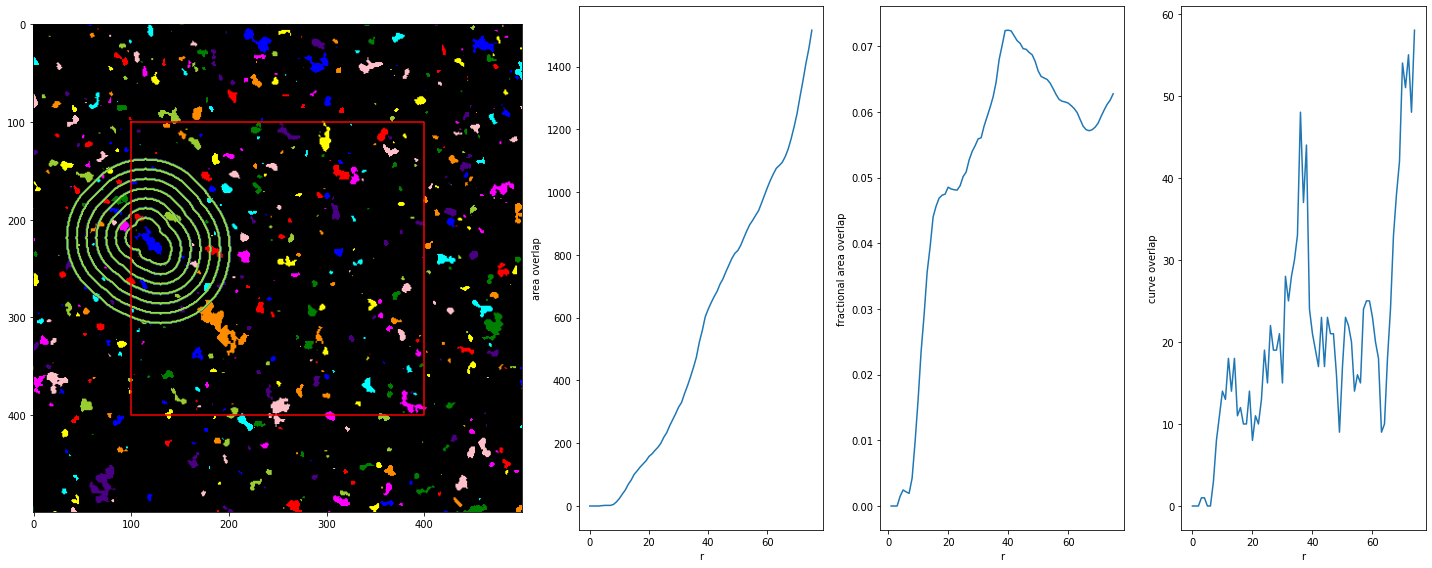

In [81]:
'''
Visualization - single cluster
'''

fig, ax = plt.subplots(1,4, figsize=(20,8), gridspec_kw={'width_ratios': [2, 1, 1, 1]})
fig.subplots_adjust(wspace=0.3)

# Plotting the ROI (red square)
bx = (L, M, M, L, L)
by = (L, L, M, M, L)
ax[0].plot(bx, by, '-r')
ax[0].imshow(label2rgb(label_image, bg_label=0))

ref_cluster = label_image_bounded == 76

rem_clusters = np.logical_and(label_image,np.invert(ref_cluster))

# 'distance_transform_edt()' computes distance from non-zero points to nearest zero
# In this example: from each back-ground-pixel to nearest cluster
D = ndimage.distance_transform_edt(ref_cluster==0)
f = np.zeros(maxR+1)
g = np.zeros(maxR+1)

# Compute total area (g) and area of clusters (f) for 
# values of r ranging from 0-100
for i in range(1,maxR+1):
    K = D<=i
    f[i] = np.count_nonzero(np.logical_and(K,rem_clusters))
    g[i] = np.count_nonzero(K)
    if (i%10==0):
        ax[0].contour(K)
        display(fig)
        clear_output(wait = True)
        

ax[1].plot(f)
ax[1].set_xlabel('r')
ax[1].set_ylabel('area overlap')

ax[2].plot(f/g)
ax[2].set_xlabel('r')
ax[2].set_ylabel('fractional area overlap')

ax[3].plot(f[1:]-f[:-1])
ax[3].set_xlabel('r')
ax[3].set_ylabel('curve overlap')

plt.tight_layout()
plt.show()

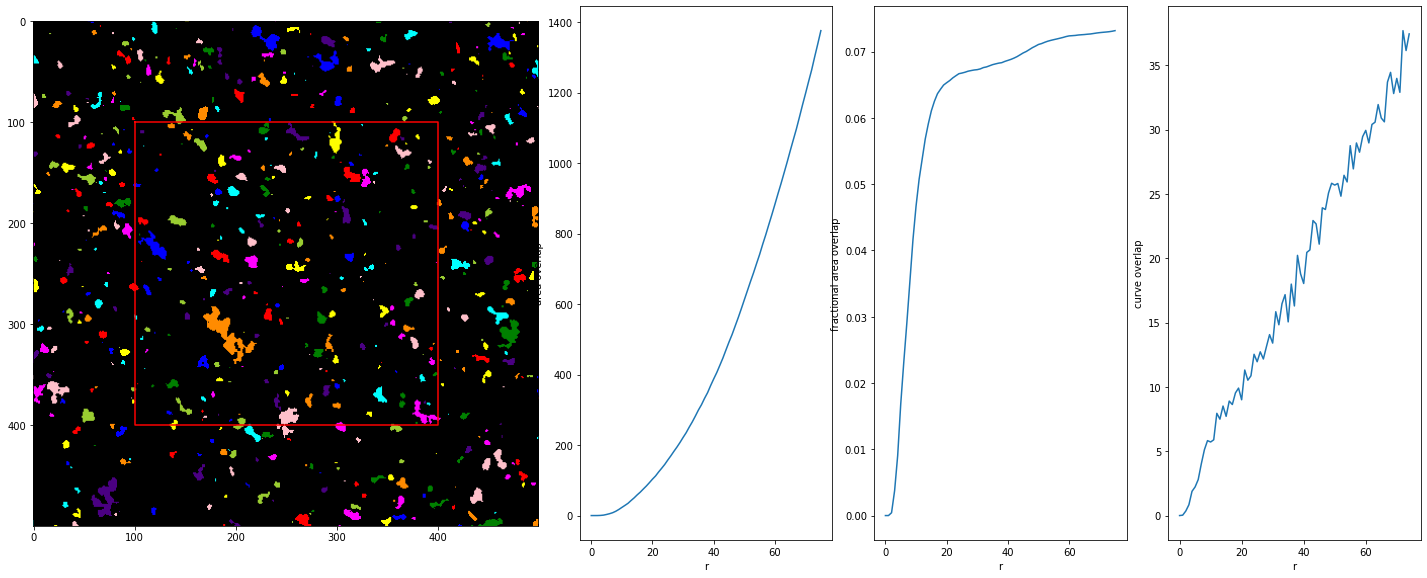

In [83]:
'''
Visualization - Compute average f,g by iterating all clusters
'''
fig, ax = plt.subplots(1,4, figsize=(20,8), gridspec_kw={'width_ratios': [2, 1, 1, 1]})
fig.subplots_adjust(wspace=0.3)
plt.tight_layout()

bx = (L, M, M, L, L)
by = (L, L, M, M, L)
ax[0].plot(bx, by, '-r')
ax[0].imshow(label2rgb(label_image, bg_label=0))
curr_image = label_image_bounded

F = np.zeros(maxR+1)
G = np.zeros(maxR+1)

for cluster in range (1, curr_image.max()+1):
    ref_cluster = curr_image == cluster
    rem_clusters = np.logical_and(label_image,np.invert(ref_cluster))
    
    D = ndimage.distance_transform_edt(ref_cluster==0)
    f = np.zeros(maxR+1)
    g = np.zeros(maxR+1)
    for i in range(0,maxR+1):
        K = D<=i
        f[i] = np.count_nonzero(np.logical_and(K,rem_clusters))
        g[i] = np.count_nonzero(K)
    F += f
    G += g


F = F / curr_image.max()
G = G / curr_image.max()

ax[1].plot(F)
ax[1].set_xlabel('r')
ax[1].set_ylabel('area overlap')

ax[2].plot(F/G)
ax[2].set_xlabel('r')
ax[2].set_ylabel('fractional area overlap')

ax[3].plot(F[1:]-F[:-1])
ax[3].set_xlabel('r')
ax[3].set_ylabel('curve overlap')
plt.show()

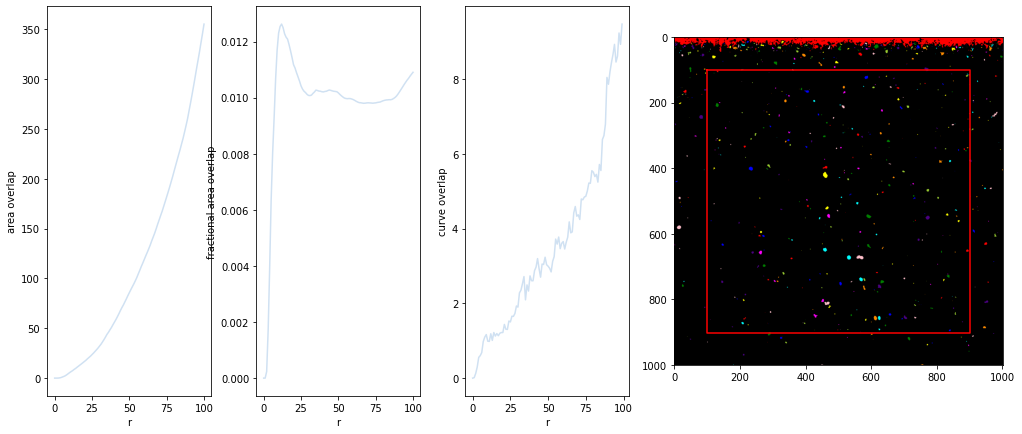

In [12]:
'''
Visualization - iterates through ceil(240/skip_size) frames.
'''

fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()

colors = cm.Blues(np.linspace(0.2, 1, len(label_video)))

    
for p, label_image in enumerate(label_video):
    L = 100 # Maximum distances to consider
    M = label_image.shape[0] - L
    maxR = 100

    label_image_bounded = np.zeros(label_image.shape, dtype=int)
    cluster_num = 1
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        if (minr > L+1) and (minc > L+1) and (maxr < M-1) and (maxc < M-1):
            pixel_coordinates = region.coords
            label_image_bounded[pixel_coordinates[:,0],  pixel_coordinates[:,1]] =  cluster_num
            cluster_num += 1

    bx = (L, M, M, L, L)
    by = (L, L, M, M, L)
    ax[3].plot(bx, by, '-r')
    ax[3].imshow(label2rgb(label_image, bg_label=0))
    curr_image = label_image_bounded

    F = np.zeros(maxR+1)
    G = np.zeros(maxR+1)
    for cluster in range(1, curr_image.max()+1):
        ref_cluster = curr_image == cluster
        rem_clusters = np.logical_and(label_image,np.invert(ref_cluster))
        
        D = ndimage.distance_transform_edt(ref_cluster==0)
        f = np.zeros(maxR+1)
        g = np.zeros(maxR+1)
        for i in range(0,maxR+1):
            K = D <= i
            f[i] = np.count_nonzero(np.logical_and(K,rem_clusters))
            g[i] = np.count_nonzero(K)
        
        F += f
        G += g 

    F = F / curr_image.max()
    G = G / curr_image.max()

    ax[0].plot(F, color=colors[p])
    ax[0].set_xlabel('r')
    ax[0].set_ylabel('area overlap')

    ax[1].plot(F/G, color=colors[p])
    ax[1].set_xlabel('r')
    ax[1].set_ylabel('fractional area overlap')

    ax[2].plot(F[1:]-F[:-1], color=colors[p])
    ax[2].set_xlabel('r')
    ax[2].set_ylabel('curve overlap')

    # Saves to folder called 'temp'
    # filename = 'frames/subplot_{:03d}.png'.format(p)
    # fig.savefig(filename)
    display(fig)
    clear_output(wait = True)
plt.show()